In [2]:
import math
import torch
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [3]:
test = torch.tensor([[-1.7],
                    #[-1.5],
                    [-0.5],
                    [-0.4],
                    [0.1],
                    #[0.15],
                    [0.38],
                    [0.41],
                    [0.7],
                    [1.9]])

In [4]:
# use regular spaced points on the interval [0, 1] (training data needs an explicit dimension)
# train_X = torch.linspace(-2, 2, 10, dtype=dtype, device=device).unsqueeze(1)
# train_X = torch.randn_like(train_X)
train_X = test
# sample observed values and add some synthetic noise
#train_Y = torch.sin(train_X * (2 * math.pi)) + 0.15 * torch.randn_like(train_X)
train_Y = torch.sin(5*train_X)*(1-torch.tanh(train_X**2))# + 0.15 * torch.randn_like(train_X)

model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-6))

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_X)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-06)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-06)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

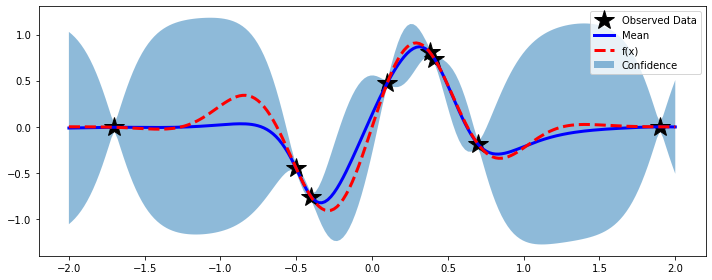

In [198]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(-2, 2, 200, dtype=dtype, device=device)
test_X = torch.cat((test_X,train_X.view(-1)))
test_X, _ = torch.sort(test_X)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*', markersize=20)
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b', linewidth=3)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    # ground truth
    truth_Y = torch.sin(5*test_X)*(1-torch.tanh(test_X**2))
    ax.plot(test_X.cpu().numpy(), truth_Y.cpu().numpy(), '--',c='r', linewidth=3)
ax.legend(['Observed Data', 'Mean', 'f(x)','Confidence'])
plt.tight_layout()
plt.savefig('GP.pdf') 

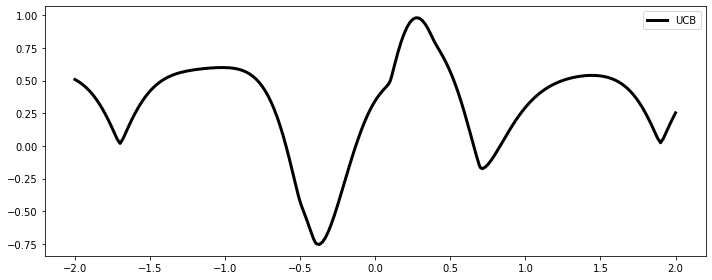

In [199]:
f, ax = plt.subplots(1, 1, figsize=(10, 4))
mean = posterior.mean.view(-1).cpu().numpy()
std = posterior.mvn.stddev.cpu().numpy()
ucb = mean + 1*std
ax.plot(test_X.cpu().numpy(), ucb, '-',c='black', linewidth=3)
ax.legend(['UCB'])
plt.tight_layout()
plt.savefig('UCB.pdf') 

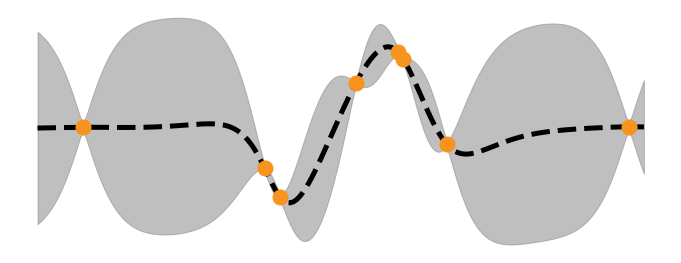

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(-2, 2, 200, dtype=dtype, device=device)
test_X = torch.cat((test_X,train_X.view(-1)))
test_X, _ = torch.sort(test_X)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), '--',c='black', linewidth=5)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color= 'grey', alpha=0.5)
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'o', color = '#F7941D', markersize=15)
    # ground truth
    truth_Y = torch.sin(5*test_X)*(1-torch.tanh(test_X**2))
    #ax.plot(test_X.cpu().numpy(), truth_Y.cpu().numpy(), '--',c='r', linewidth=3)
#ax.legend(['Observed Data', 'Mean', 'f(x)','Confidence'])
plt.tight_layout()
plt.axis('off')
plt.savefig('GP_0802.pdf') 

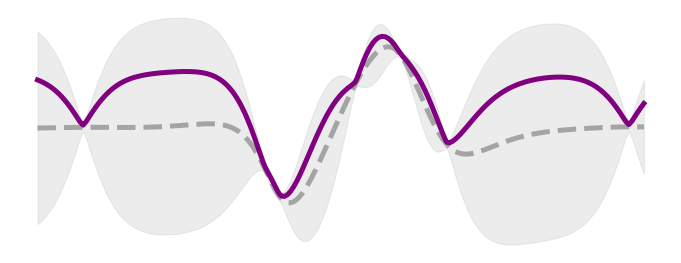

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(-2, 2, 200, dtype=dtype, device=device)
test_X = torch.cat((test_X,train_X.view(-1)))
test_X, _ = torch.sort(test_X)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), '--', c='black', linewidth=5, alpha = 0.3)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color= 'grey', alpha=0.15)
    # Plot training points as black stars
    #ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'o', color = '#F7941D', markersize=15)
    # ground truth
    truth_Y = torch.sin(5*test_X)*(1-torch.tanh(test_X**2))
    #ax.plot(test_X.cpu().numpy(), truth_Y.cpu().numpy(), '--',c='r', linewidth=3)
    mean = posterior.mean.view(-1).cpu().numpy()
    std = posterior.mvn.stddev.cpu().numpy()
    ucb = mean + 1*std
    ax.plot(test_X.cpu().numpy(), ucb, '-',c='purple', linewidth=5)
#ax.legend(['Observed Data', 'Mean', 'f(x)','Confidence'])
plt.tight_layout()
plt.axis('off')
plt.savefig('AF_0802.pdf') 

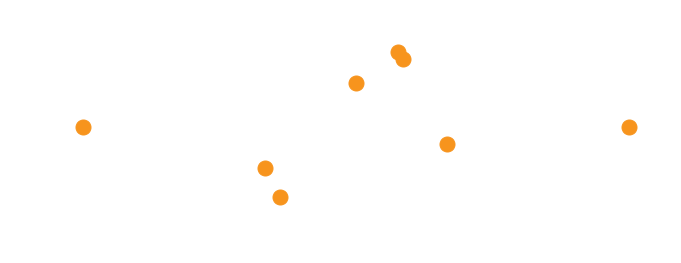

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(-2, 2, 200, dtype=dtype, device=device)
test_X = torch.cat((test_X,train_X.view(-1)))
test_X, _ = torch.sort(test_X)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), '--',c='white', linewidth=5)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color= 'white', alpha=0.5)
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'o', color = '#F7941D', markersize=15)
    # ground truth
    truth_Y = torch.sin(5*test_X)*(1-torch.tanh(test_X**2))
    #ax.plot(test_X.cpu().numpy(), truth_Y.cpu().numpy(), '--',c='r', linewidth=3)
#ax.legend(['Observed Data', 'Mean', 'f(x)','Confidence'])
plt.tight_layout()
plt.axis('off')
plt.savefig('GP_initial_data.pdf') 

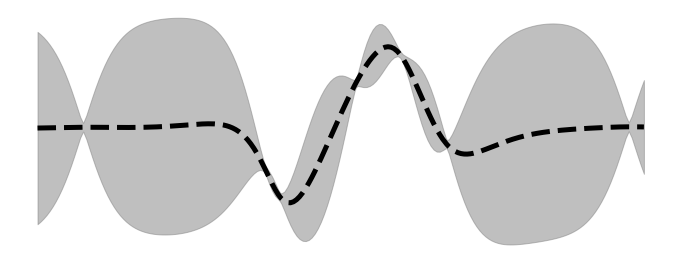

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(-2, 2, 200, dtype=dtype, device=device)
test_X = torch.cat((test_X,train_X.view(-1)))
test_X, _ = torch.sort(test_X)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), '--',c='black', linewidth=5)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color= 'grey', alpha=0.5)
    # Plot training points as black stars
    #ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'o', color = '#F7941D', markersize=15)
    
    #ax.plot(test_X.cpu().numpy(), truth_Y.cpu().numpy(), '--',c='r', linewidth=3)
#ax.legend(['Observed Data', 'Mean', 'f(x)','Confidence'])
plt.tight_layout()
plt.axis('off')
plt.savefig('GP_mean_str.pdf') 

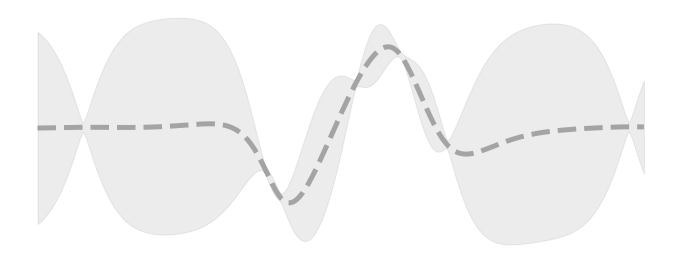

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(-2, 2, 200, dtype=dtype, device=device)
test_X = torch.cat((test_X,train_X.view(-1)))
test_X, _ = torch.sort(test_X)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), '--', c='black', linewidth=5, alpha = 0.3)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color= 'grey', alpha=0.15)
    # Plot training points as black stars
    #ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'o', color = '#F7941D', markersize=15)
    # ground truth
    truth_Y = torch.sin(5*test_X)*(1-torch.tanh(test_X**2))
    #ax.plot(test_X.cpu().numpy(), truth_Y.cpu().numpy(), '--',c='r', linewidth=3)
    mean = posterior.mean.view(-1).cpu().numpy()
    std = posterior.mvn.stddev.cpu().numpy()
    ucb = mean + 1*std
    #ax.plot(test_X.cpu().numpy(), ucb, '-',c='purple', linewidth=5)
#ax.legend(['Observed Data', 'Mean', 'f(x)','Confidence'])
plt.tight_layout()
plt.axis('off')
plt.savefig('AF_gray.pdf') 